# Blame: ES or SNN?

This notebook contains three tasks for ES just to make sure it actaully works because it is apparently not working on SNN.

In [6]:
from EvolutionStrategy import ESParameter, ESModel

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim

device = 'cuda'

## 1. Test on Trivial Loss Landscape

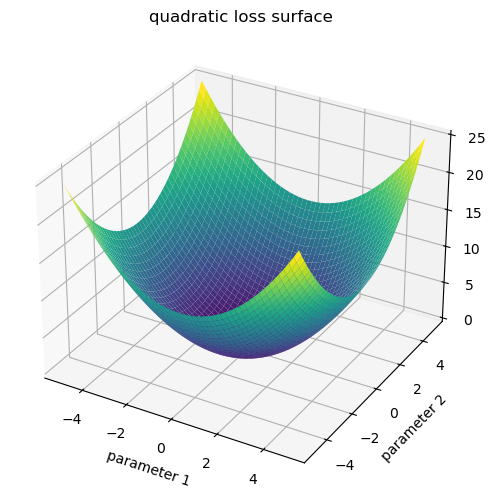

In [ ]:
def plot_landscape():
    # Create a meshgrid for X and Y
    x = np.linspace(-5, 5, 50)
    y = np.linspace(-5, 5, 50)
    X, Y = np.meshgrid(x, y)

    # Define a function for Z
    Z = (X**2 + Y**2) / 2

    # Create a figure and 3D axis
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    ax.plot_surface(X, Y, Z, cmap='viridis')

    # Labels
    ax.set_xlabel('parameter 1')
    ax.set_ylabel('parameter 2')

    ax.set_title('quadratic loss surface')

    # Show the plot
    # plt.tight_layout()
    plt.show()
    
plot_landscape()

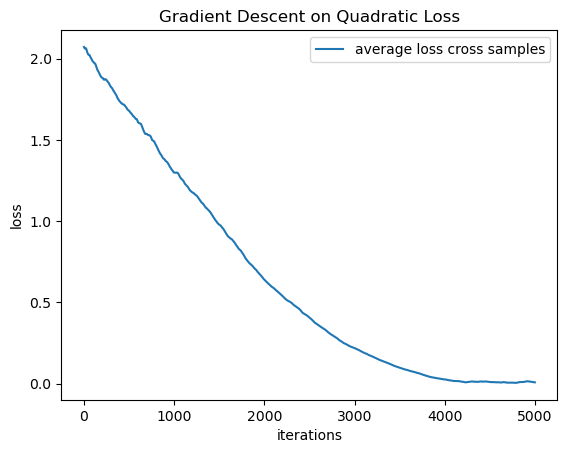

In [7]:
def quadratic_landscape(params):
    # params is of dimension: [nb_samples, ...params shape....]
    # so number of params is nubmer of elements in params shape
    nb_params = torch.numel(params[0])
    
    # the dimensions to sum are all but the first dim
    dims_to_sum = tuple(range(1, params.dim()))
    
    # normalize by number of parameters
    return torch.sum(params ** 2, dim=dims_to_sum) / nb_params 

def gradient_descent_for_dummy(param_to_loss):
    param_shape = [4,4]
    param_scale = 5
    param = ESParameter(para_means=torch.rand(param_shape).to(device) * param_scale, para_std=0.3, Optimizer=optim.Adam)
    
    
    average_loss_cross_samples = []
    for _ in range(5000):
        param_samples = param.sample(sample_size=30)        
        
        # loss shape: [nb_samples,]
        loss = param_to_loss(param_samples)
        
        param.gradient_descent(loss)
        average_loss_cross_samples.append(torch.mean(param.means).cpu())   
    
    plt.plot(average_loss_cross_samples, label='average loss cross samples')
    plt.xlabel('iterations')
    plt.ylabel('loss')
    plt.title('Gradient Descent on Quadratic Loss')
    plt.legend()
    plt.show()
    
gradient_descent_for_dummy(quadratic_landscape)

## 2. ES on CNN on MNIST

In [ ]:
from EvolutionStrategy import ESModel

import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Compose, Normalize
import torch.nn.functional as F
from torch import nn
import torch.optim as optim

device = 'cuda'

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [ ]:
from sklearn.model_selection import train_test_split
import wandb
import os

def _run_snn_on_batch(model, x, y, loss_fn): 
    pred = model(x)
    
    loss = loss_fn(pred, y)
    correct = (pred.argmax(1) == y).type(torch.float).sum().item()
    
    return loss, correct

def log_model(es_model,run):
    filename = 'best-model.pth'
    model = es_model.get_best_model()
    torch.save(model.state_dict(), filename)
    run.log_model(path=filename)
    os.remove(filename)  

def val_loop_snn(es_model, dataloader, loss_fn):
    model = es_model.get_best_model()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        batch_loss, batch_correct = _run_snn_on_batch(model, x, y, loss_fn) 
        test_loss += batch_loss
        correct += batch_correct

    test_loss /= num_batches
    test_acc = correct / size
    print(f"Test Error: \nAccuracy: {(100*test_acc):>0.1f}%, Avg loss: {test_loss:>8f} \n")
        
    return test_loss.item(), test_acc

def train_loop_snn(es_model, train_dataloader, val_dataloader, loss_fn, nb_model_samples, run):
    """ one epoch of training, going through all the batches once
    """    
    for batch, (x, y) in enumerate(train_dataloader):
        x, y = x.to(device), y.to(device)
        # train model with samples
        samples_loss = []
        for model in es_model.samples(nb_model_samples):
            loss, _ = _run_snn_on_batch(model, x, y, loss_fn)
            samples_loss.append(loss)            
            
        samples_loss = torch.stack(samples_loss) 
        es_model.gradient_descent(samples_loss)
    
        # best model loss and accuracy
        best_model = es_model.get_best_model()
        best_loss, best_correct = _run_snn_on_batch(best_model, x, y, loss_fn)   
        best_acc = best_correct / len(y)
        print(f"batch {batch}, loss: {best_loss:>7f}, accuracy: {100 * best_acc:>0.1f}%")
        
        # validation loss and accuracy
        val_loss, val_acc = val_loop_snn(es_model, val_dataloader, loss_fn)
        
        # record keeping
        run.log({'train_loss': best_loss.item(), 'train_acc' : best_acc, 'val_loss': val_loss, 'val_acc': val_acc}) 
        # log_model(es_model, run)

In [ ]:
def train_snn():   
    run_name = 'first-attempt'
    config = {'nb_model_samples': 1000,
              'std': 0.05,
              'lr': 0.01,
              'epochs': 25}
    with torch.no_grad(), wandb.init(entity = 'DarwinNeuron', project = 'ES-CNN-MNIST', name=run_name, config=config) as run:  
        train_dataloader = torch.utils.data.DataLoader(
            datasets.MNIST('data', train=True, download=True,
                                transform=Compose([
                                ToTensor(),
                                Normalize((0.1307,), (0.3081,))
                                ])),
            batch_size=256, shuffle=True)

        val_dataloader = torch.utils.data.DataLoader(
            datasets.MNIST('data', train=False, download=True,
                                        transform=Compose([
                                        ToTensor(),
                                        Normalize((0.1307,), (0.3081,))
                                        ])),
            batch_size=1000, shuffle=True)     
        es_model = ESModel(CNN, param_std = run.config.std, Optimizer=optim.Adam, lr=run.config.lr)
        for epoch in range(run.config.epochs):
            print(f"Epoch {epoch}\n-------------------------------")
            # train the model
            train_loop_snn(es_model,train_dataloader, val_dataloader, cross_entropy, run.config.nb_model_samples, run)
    
train_snn() 

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: yixing to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 0
-------------------------------
batch 0, loss: 2.321057, accuracy: 11.3%
Test Error: 
Accuracy: 11.3%, Avg loss: 2.319351 

batch 1, loss: 2.323903, accuracy: 10.2%
Test Error: 
Accuracy: 11.3%, Avg loss: 2.319230 

batch 2, loss: 2.318732, accuracy: 11.7%
Test Error: 
Accuracy: 11.3%, Avg loss: 2.320920 

batch 3, loss: 2.321547, accuracy: 10.5%
Test Error: 
Accuracy: 11.4%, Avg loss: 2.322474 

batch 4, loss: 2.314988, accuracy: 9.8%
Test Error: 
Accuracy: 9.3%, Avg loss: 2.324321 

batch 5, loss: 2.341904, accuracy: 9.4%
Test Error: 
Accuracy: 7.8%, Avg loss: 2.326103 

batch 6, loss: 2.334600, accuracy: 7.0%
Test Error: 
Accuracy: 8.5%, Avg loss: 2.327410 

batch 7, loss: 2.312607, accuracy: 10.2%
Test Error: 
Accuracy: 9.2%, Avg loss: 2.329340 

batch 8, loss: 2.339482, accuracy: 8.6%
Test Error: 
Accuracy: 9.5%, Avg loss: 2.330334 

batch 9, loss: 2.344823, accuracy: 9.4%
Test Error: 
Accuracy: 9.6%, Avg loss: 2.331204 

batch 10, loss: 2.326989, accuracy: 13.7%
Test Erro

Traceback (most recent call last):
  File "/tmp/ipykernel_10694/1872670006.py", line 27, in train_snn
    train_loop_snn(es_model,train_dataloader, val_dataloader, cross_entropy, run.config.nb_model_samples, run)
  File "/tmp/ipykernel_10694/3273294460.py", line 45, in train_loop_snn
    for model in es_model.samples(nb_model_samples):
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/wyx/darwin_neuron/EvolutionStrategy.py", line 112, in samples
    yield(self._params_to_model(param_list))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/wyx/darwin_neuron/EvolutionStrategy.py", line 100, in _params_to_model
    model = self.Model(*self.model_args).to(device)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/wyx/miniconda3/envs/snn/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1340, in to
    return self._apply(convert)
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/wyx/miniconda3/envs/snn/lib/python3.12/site-packages/torch/nn/mod

BrokenPipeError: [Errno 32] Broken pipe

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f74e2af9880>> (for post_run_cell), with arguments args (<ExecutionResult object at 7f74cb57f4a0, execution_count=6 error_before_exec=None error_in_exec=[Errno 32] Broken pipe info=<ExecutionInfo object at 7f74cb49ede0, raw_cell="def train_snn():   
    run_name = 'first-attempt'.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://wsl%2Bubuntu-22.04/home/wyx/darwin_neuron/ES-CNN-MNIST.ipynb#W4sdnNjb2RlLXJlbW90ZQ%3D%3D> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

Observation:
- As I increase the std of parameters, the loss start to increase as well. When std = 1, the loss blows up. 
    - can i normalize layer to solve this problem? the output of each layer shouldn't be affected so much by the initialization of weights? Also, what makes this blow up (how does the weights work here)? 
- Adaptive STD ??!!! from large to small

## 3. Single Neuron Optimization Task

ES with SNN was a failure so we will try a simpler one parameter model mentioned in the ES paper. The task is to minimize number of spikes

In [ ]:
from EvolutionStrategy import ESModel
from Utilities import spike_count

from torch import optim
import wandb

class SingleNeuron(nn.Module):
    def __init__(self):
        super().__init__()
        self.neuron = snn.Leaky(beta=0.85, learn_beta=False, threshold=0.5)
        self.i_app = torch.nn.parameter.Parameter(torch.tensor([2.,]),requires_grad=False)
    def forward(self):
        mem = self.neuron.init_leaky()
        spk_rec = []
        for _ in range(100):
            spk, mem = self.neuron(self.i_app, mem)    
            spk_rec.append(spk)
        return torch.stack(spk_rec, dim=0)        

def train_single_neuron():
    config = {
        'std': 1,
        'lr': 0.01,
        'nb_sample': 100,
        'epochs': 1000
    }
    
    with torch.no_grad(), wandb.init(entity = 'DarwinNeuron', project = 'SingleNeuron', name = 'name?', config = config) as run:
        es_model = ESModel(Model=SingleNeuron, param_std = run.config.std, Optimizer=optim.Adam, lr = run.config.lr)
        run.log({'I_app': es_model.get_best_model().i_app.item()})
        for epoch in range(1, run.config.epochs + 1):            
            losses = []
            for model in es_model.samples(run.config.nb_sample):
                spike_train = model()
                model_loss = spike_count(spike_train).float()
                losses.append(model_loss)
                
            losses = torch.stack(losses)
            es_model.gradient_descent(losses)
            run.log({'I_app': es_model.get_best_model().i_app.item(), 
                     'estimated_loss': ESModel.estimated_loss(losses),
                     'val_loss': spike_count(es_model.get_best_model().forward())})
            print(f"loss: {losses.mean():>7f}")
            
        return es_model.get_best_model()

# best_neuron = train_single_neuron()
            
            